In [6]:
from collections import defaultdict
from itertools import product, combinations
import random
import numpy as np
import matplotlib.pyplot as plt
from utility import *


# === STATE GENERATION ===
def getPossibleStates(edges, max_age):
    sorted_edges = sorted(tuple(sorted(e)) for e in edges)
    possible_ages = [-1] + list(range(1, max_age + 1))
    return [
        tuple(zip(sorted_edges, age_combo))
        for age_combo in product(possible_ages, repeat=len(sorted_edges))
    ]

# === STATE UPDATE HELPERS ===
def age_entanglements(state, maxAge):
    new_state = []
    for edge, age in state:
        if age == -1:
            new_state.append((edge, -1))
        else:
            new_age = age + 1
            new_state.append((edge, new_age if new_age <= maxAge else -1))
    return tuple(sorted(new_state))

def generate_entanglements(state, pGen):
    new_state = []
    for edge, age in state:
        if age == -1 and random.random() < pGen:
            new_state.append((edge, 1))
        else:
            new_state.append((edge, age))
    return tuple(sorted(new_state))

# # === REWARD FUNCTION WITH LAPLACE SMOOTHING ===
# def getImmediateReward(achieved_goals, goal_success_counts, total_timesteps):
#     if achieved_goals is None:
#         return 0
#     reward = 0
#     for goal, success in achieved_goals:
#         if success:
#             hops = abs(goal[1] - goal[0])
#             rate = pSwap ** (hops - 1)
#             smoothed_edr = (goal_success_counts[goal] + 1) / (total_timesteps + 5)
#             reward += np.log(rate / smoothed_edr + 1e-5)
#     return reward
def getImmediateReward(achieved_goals, goal_success_counts, total_timesteps):
    if achieved_goals is None:
        return 0

    total_reward = 0
    for goal_edge, success in achieved_goals:
        if success:
            start, end = goal_edge
            num_edges = abs(end - start)
            instant_rate = pSwap ** (num_edges - 1)
            edr = goal_success_counts[goal_edge] / max(1, total_timesteps) + 0.001
            if instant_rate > 0 and edr > 0:
                total_reward += instant_rate / edr
    return total_reward

# === TRANSITION MODEL (RESTORED & FIXED FAILURE HANDLING) ===
def generateAllStateTransitions(edges, goalEdges, pSwap, pGen, maxAge):
    transitions = {}
    all_states = getPossibleStates(edges, maxAge)
    for state in all_states:
        transitions[state] = defaultdict(list)

        # No-op action
        aged_state = age_entanglements(state, maxAge)
        final_state = generate_entanglements(aged_state, pGen)
        transitions[state][((), None)].append((final_state, 1.0, None))

        # Attempt each goal individually
        for goal in goalEdges:
            path = get_path(goal, state)
            if path is None:
                continue
            used_edges = set(path)
            success_prob = pSwap ** (len(path) - 1)
            fail_prob = 1 - success_prob

            # On success: clear used edges
            cleared_state = tuple((e, -1) if e in used_edges else (e, a) for e, a in state)
            aged = age_entanglements(cleared_state, maxAge)
            final = generate_entanglements(aged, pGen)
            transitions[state][(tuple(path), goal)].append((final, success_prob, [(goal, True)]))

            # On failure: also clear used edges
            cleared_on_fail = tuple((e, -1) if e in used_edges else (e, a) for e, a in state)
            aged_fail = age_entanglements(cleared_on_fail, maxAge)
            final_fail = generate_entanglements(aged_fail, pGen)
            transitions[state][(tuple(path), goal)].append((final_fail, fail_prob, [(goal, False)]))
            


    return transitions

def get_path(goal, state):
    graph = defaultdict(list)
    for (e1, e2), age in state:
        if age > 0:
            graph[e1].append(e2)
            graph[e2].append(e1)
    start, end = goal
    visited = set()
    queue = [(start, [])]
    while queue:
        current, path = queue.pop(0)
        if current == end:
            return path
        if current in visited:
            continue
        visited.add(current)
        for neighbor in graph[current]:
            if neighbor not in visited:
                queue.append((neighbor, path + [tuple(sorted((current, neighbor)))]))
    return None

# === SIMULATE POLICY WITH SOFTMAX ACTION SELECTION ===
def simulate_policy_fixed_qvalue(policy, all_transitions, goalEdges, initial_state, episodes=10, steps=10000):
    all_episode_edr_histories = []

    for ep in range(episodes):
        goal_success_counts = {goal: 0 for goal in goalEdges}
        total_timesteps = 1
        edr_history = {goal: [] for goal in goalEdges}

        state = initial_state
        for step in range(steps):
            if state not in all_transitions:
                break

            action_rewards = {}
            for action, transitions in all_transitions[state].items():
                expected_reward = 0
                for next_state, prob, achieved_goals in transitions:
                    reward = getImmediateReward(achieved_goals, goal_success_counts, total_timesteps)
                    expected_reward += prob * reward
                action_rewards[action] = expected_reward

            if not action_rewards:
                break

            actions, rewards = zip(*action_rewards.items())
            exp_rewards = np.exp(np.array(rewards) / temp)
            probs = exp_rewards / np.sum(exp_rewards)
            best_action = random.choices(actions, weights=probs, k=1)[0]

            transition = random.choices(
                all_transitions[state][best_action],
                weights=[t[1] for t in all_transitions[state][best_action]]
            )[0]

            next_state, prob, achieved_goals = transition
            reward = getImmediateReward(achieved_goals, goal_success_counts, total_timesteps)

            for goal, success in (achieved_goals or []):
                if success:
                    goal_success_counts[goal] += 1

            total_timesteps += 1
            for goal in goalEdges:
                edr = goal_success_counts[goal] / total_timesteps
                edr_history[goal].append(edr)
                print(f"EDR for goal {goal}: {edr:.4f}")

            state = age_entanglements(next_state, maxAge)
            state = generate_entanglements(state, pGen)

        all_episode_edr_histories.append(edr_history)

    print("[DEBUG] Completed all episodes.")
    return all_episode_edr_histories


def run_q_value_iteration(edges, goalEdges, pSwap, pGen, maxAge, gamma=0.99, epsilon=0.001, max_iterations=1000, plot=True):

    q_table = qTable()
    V = {}
    value_history = []
    delta_history = []

    edr_history = {goal: [] for goal in goalEdges}

    all_states = getPossibleStates(edges, maxAge)
    all_transitions = generateAllStateTransitions(edges, goalEdges, pSwap, pGen, maxAge)

    for iteration in range(max_iterations):
        delta = 0
        new_V = {}

        for state in all_states:
            best_action_value = float('-inf')
            for action, transitions in all_transitions[state].items():
                expected_value = 0.0
                for next_state, prob, achieved_goals in transitions:
                    reward = getImmediateReward(achieved_goals, defaultdict(int), 1)
                    next_state_value = V.get(next_state, 0.0)
                    expected_value += prob * (reward + gamma * next_state_value)

                q_table.set_q_value(state, action, expected_value)
                if expected_value > best_action_value:
                    best_action_value = expected_value

            new_V[state] = best_action_value
            delta = max(delta, abs(V.get(state, 0.0) - best_action_value))
            delta_history.append(delta)


        V = new_V
        max_value = max(V.values()) if V else 0
        value_history.append(max_value)

        if iteration % 1000 == 0:
            print(f"[Iteration {iteration}] Max ΔV: {delta:.6f} | Max V(s): {max_value:.4f}")

        if delta < epsilon:
            print(f"[Converged] Iteration {iteration} with delta {delta:.6f}")
            break
    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(delta_history, 'b-', label='Max ΔV (Convergence Metric)')
        plt.title("Value Iteration Convergence")
        plt.xlabel("Iteration")
        plt.ylabel("Delta (max change in V)")
        plt.yscale('log')  # Optional: log scale to better visualize convergence
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return q_table, V, edr_history, value_history, all_transitions


# === CONFIGURATION ===
edges = [(0, 1), (1, 2), (2, 3), (3, 4)]
goalEdges = [(0, 4), (2, 4)]
pSwap = 0.8
pGen = 0.8
maxAge = 2
gamma = 0.99
epsilon = 0.0001
max_iterations = 50000 
num_steps= 10000
temp = 1.0  # Temperature for softmax
num_simulations = 30
def train_value_iteration_policy(edges, goal_edges, p_swap, p_gen, max_age, seed=None, **kwargs):
    Q, _, _, _, _ = run_q_value_iteration(
        edges=edges,
        goalEdges=goal_edges,
        pSwap=p_swap,
        pGen=p_gen,
        maxAge=max_age,
        plot=False,
        **kwargs
    )
    return Q


# === Step 1: Train the policy (or load an existing Q_table) ===
Q = train_value_iteration_policy(
    edges=edges,
    goal_edges=goalEdges,
    p_swap=pSwap,
    p_gen=pGen,
    max_age=maxAge,
    gamma=gamma,
    epsilon=epsilon,
    max_iterations=max_iterations
)




results = validate_policy_simulation(
    Q_table=Q,
    edges=edges,
    goal_edges=goalEdges,
    p_swap=pSwap,
    p_gen=pGen,
    max_age=maxAge,
    num_steps=num_steps,
    num_simulations=num_simulations,
    seed=27,
    plot=True,        # <--- Enable plotting
    window=1000     # <--- How many final steps to average
)



[Iteration 0] Max ΔV: 640.000000 | Max V(s): 640.0000
[Iteration 1000] Max ΔV: 0.020403 | Max V(s): 47816.9595
[Converged] Iteration 1530 with delta 0.000099


KeyboardInterrupt: 

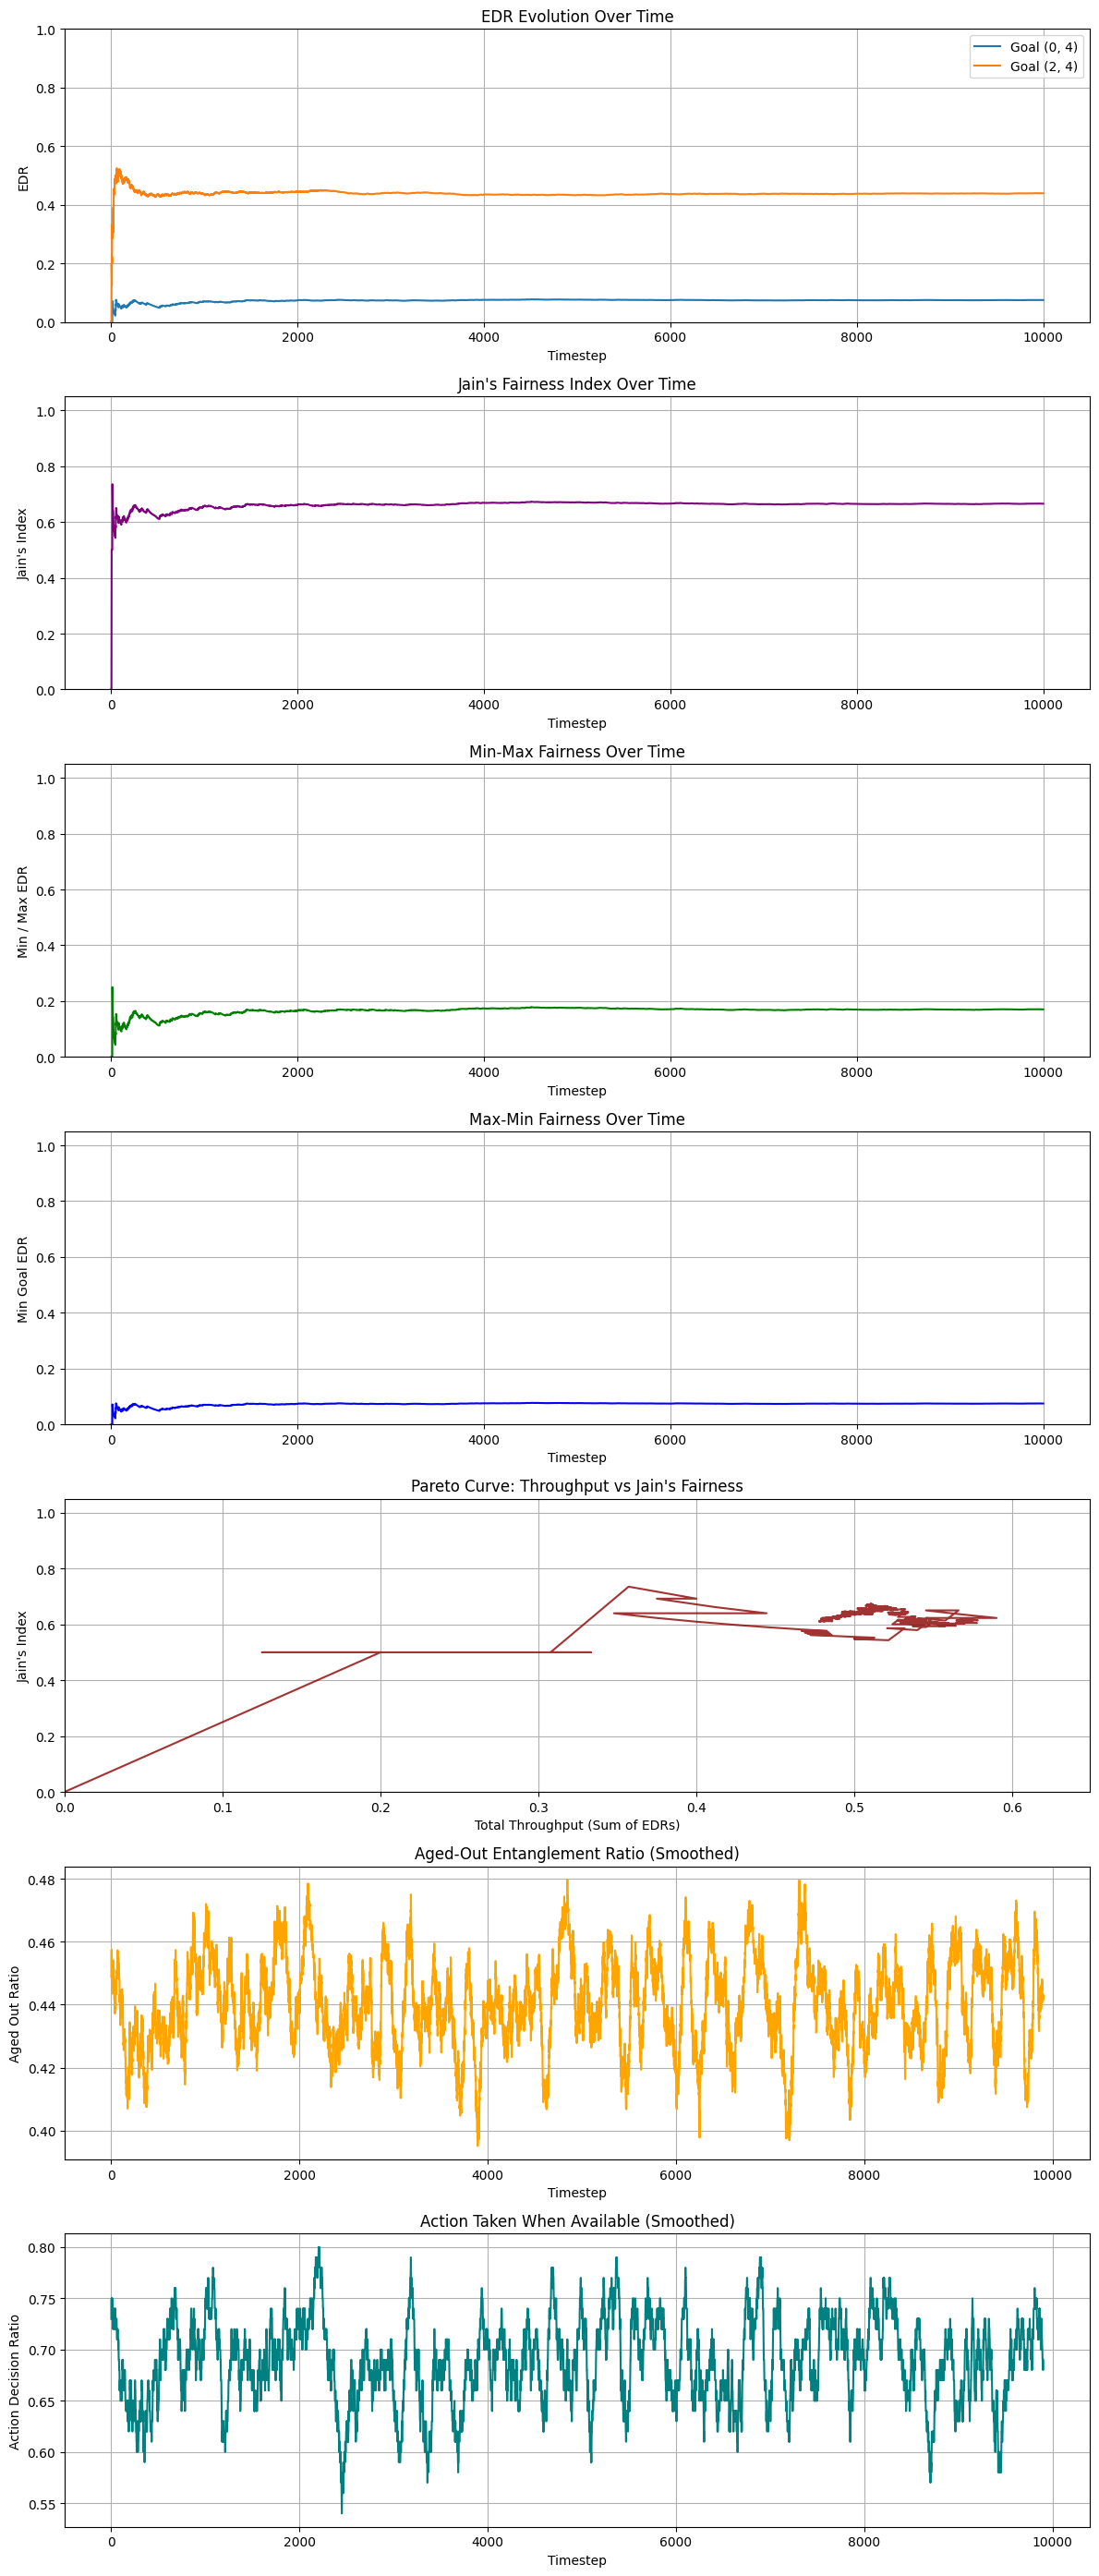

In [10]:

results = simulate_policy(
    Q_table=Q,
    edges=edges,
    goal_edges=goalEdges,
    p_swap=pSwap,
    p_gen=pGen,
    max_age=maxAge,
    num_steps=10000,
    plot=True,        # <--- Enable plotting
)


In [ ]:

# === Sweep Parameters for Value Iteration ===
param_name = "pGen"
param_values = [0.2 * i for i in range(1, 5)]  # Example: [0.2, 0.4, 0.6, 0.8]

compare_policies_across_param(
    policy_name="Value Iteration",
    policy_train_fn=train_value_iteration_policy,
    param_name=param_name,
    param_values=param_values,
    edges=edges,
    goal_edges=goalEdges,
    p_gen=pGen,  # gets overridden
    p_swap=pSwap,
    max_age=maxAge,
    train_kwargs={
        "gamma": gamma,
        "epsilon": epsilon,
        "max_iterations": max_iterations
    },
    plot=True,
    num_runs=10,
    num_steps=50000,
    num_simulations=10
)



=== Evaluating Value Iteration for pGen = 0.2 ===

=== Value Iteration (pGen=0.2) Policy Training Run 1 ===
[Iteration 0] Max ΔV: 640.000000 | Max V(s): 640.0000
[Converged] Iteration 7 with delta 0.000000

=== Value Iteration (pGen=0.2) Policy Training Run 2 ===
[Iteration 0] Max ΔV: 640.000000 | Max V(s): 640.0000
[Converged] Iteration 10 with delta 0.000000

=== Value Iteration (pGen=0.2) Policy Training Run 3 ===
[Iteration 0] Max ΔV: 640.000000 | Max V(s): 640.0000
[Iteration 1000] Max ΔV: 0.012614 | Max V(s): 21610.3934
[Converged] Iteration 1482 with delta 0.000099

=== Value Iteration (pGen=0.2) Policy Training Run 4 ===
[Iteration 0] Max ΔV: 640.000000 | Max V(s): 640.0000
[Converged] Iteration 7 with delta 0.000000

=== Value Iteration (pGen=0.2) Policy Training Run 5 ===
[Iteration 0] Max ΔV: 640.000000 | Max V(s): 640.0000
[Iteration 1000] Max ΔV: 0.008526 | Max V(s): 19547.8478
[Converged] Iteration 1443 with delta 0.000099

=== Value Iteration (pGen=0.2) Policy Training 